# Definição e import das bibliotecas utilizadas

In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from skimage import io, color
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Etapas de Pré - Processamento

## Conversão para escala de Cinza

- Essa etapa é importante para garantir que a imagem possa passar adequadamente pela etapa de binarização. Para que a binarização ocorra adequadamente, é preciso que a imagem tenha apenas um canal de cor. Como as assinaturas fornecidas possuem 3 canais (imagem RGB), reduz-se os canais para um único canal em escala de cinza e, posteriormente, aplica-se a binarização, definindo a intensidade dos pixels como 0 ou 255 a partir de algum limiar de decisão.

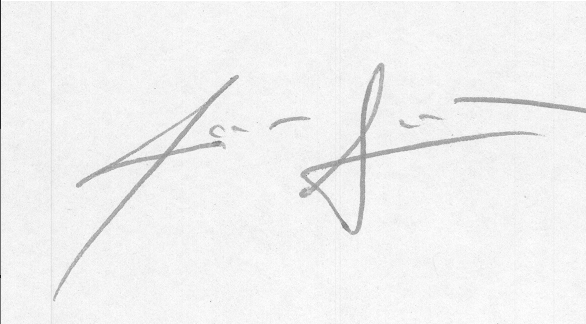

## Binarização:
- A binarização foi realizada na função binarization, a qual recebe uma imagem e, a partir do algoritmo de Otsu, define um treshold e devolve uma imagem binarizada, com o canal de cores único contendo pixels de valor 0 (preto) ou 255 (branco). O algoritmo de Otsu é uma técnica de segmentação de imagens que busca automaticamente determinar o melhor valor de limiar para binarizar uma imagem. Ele funciona encontrando o limiar que minimiza a variabilidade intra-classe (variabilidade dentro das duas classes de pixels resultantes da binarização: pixels brancos e pixels pretos). Em outras palavras, ele tenta encontrar o limiar que melhor separa os objetos de interesse do fundo na imagem, maximizando a diferença entre os objetos e o fundo.

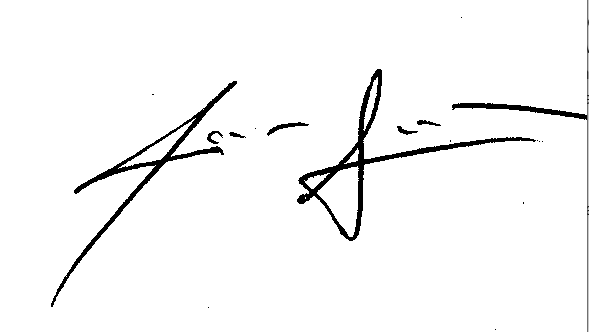

## Inversão da intensidade dos Pixels:

- De modo a facilitar a visualização e ressaltar as características da imagem, além da presença de ruídos, fez-se a inversão da intensidade dos pixels.

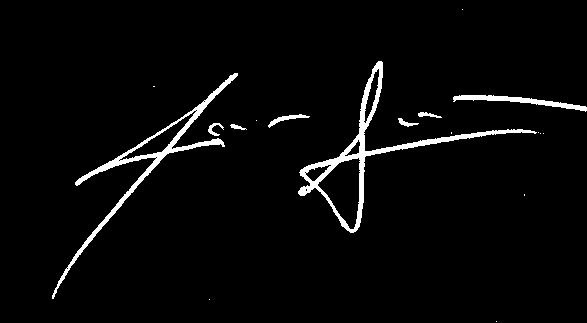

## Aplicação de Filtro Bilateral para retirada de ruído:

O filtro bilateral é aplicado a cada pixel da imagem, substituindo seu valor pela média ponderada dos valores dos pixels vizinhos, onde os pesos são determinados pela função de peso bilateral.

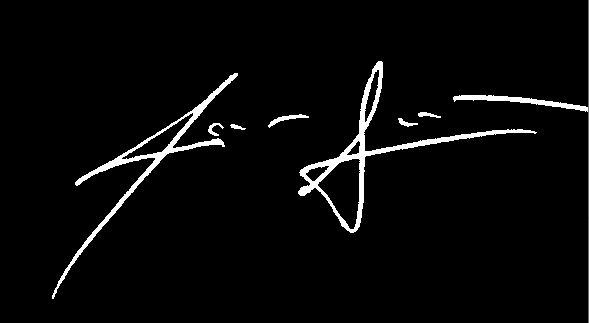

## Recorte da imagem, mantendo a imagem centralizada na tela:

- Ao recortar a imagem e remover o fundo que não contém a assinatura, forneceu-se ao modelo de verificação de assinaturas uma entrada mais relevante e significativa.


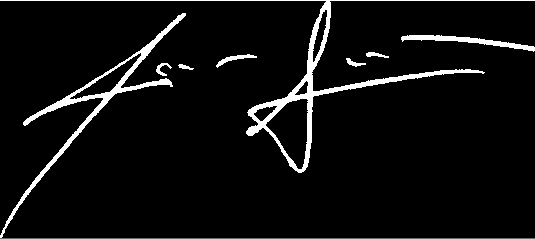

## Normalização do tamanho das imagens

- Aqui, fixou-se o tamanho de todas as imagens em um tamanho padrão. Isto é necessário para facilitar a extração das características pela rede neural e reduzir o custo computacional. Além disso, deixar a imagem quadrada (isto é, com mesma altura e comprimento), simplifica o pré-processamento dos dados, pois não precisa lidar com tamanhos variáveis de imagem durante o treinamento e a inferência.
Além disso, muitas implementações de redes convolucionais utilizam camadas de convolução e pooling que operam melhor em imagens com dimensões iguais. Manter a imagem quadrada pode ajudar a evitar distorções indesejadas durante o processamento.


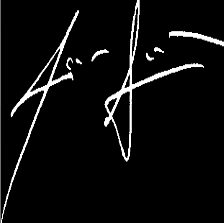

In [3]:
def binarization(image):
  limiar, imagem_binaria = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return imagem_binaria

def recortar(imagem):
  vetor_linhas = []
  vetor_colunas = []
  linhas, colunas = imagem.shape
  for linha in range(linhas):
    if 255 in imagem[linha,:]:
      vetor_linhas.append(linha)
  for coluna in range(colunas):
    if 255 in imagem[:,coluna]:
      vetor_colunas.append(coluna)
  imagem_nova = imagem[min(vetor_linhas):max(vetor_linhas), min(vetor_colunas):max(vetor_colunas)]
  return imagem_nova

#-----------------------------------
def pre_process(imagem):
  imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
  #cv2.imshow('Imagem em escala de cinza', imagem_gray)
  #-----------------------------------
  binary_image = binarization(imagem_gray)
  #cv2.imshow('Imagem binarizada', binary_image)
  #-----------------------------------
  imagem_nova = cv2.bitwise_not(binary_image)
  #cv2.imshow('Imagem invertida', imagem_nova)
  #-----------------------------------
  diameter = 5 # Diâmetro da vizinhança para cálculo da média
  sigma_color = 250  # Valor sigma para a componente de cor
  sigma_space = 250  # Valor sigma para a componente espacial
  imagem_filtrada = binarization(cv2.bilateralFilter(imagem_nova, diameter, sigma_color, sigma_space))
  imagem_recortada = recortar(imagem_filtrada)
  imagem = imagem_recortada
  #cv2.imshow('Imagem Filtrada (Bilateral)', imagem_filtrada)
  #-----------------------------------
  imagem_final = color.gray2rgb(cv2.resize(imagem, (224,224)))
  imagem_final = preprocess_input(imagem_final)
  #cv2.imshow('Imagem Esqueleto', new_skeleton)
  #cv2.imshow('Imagem Final', new_skeleton)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()
  return imagem_final

# Carregamento das imagens a partir do Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
caminho_org = "/content/drive/My Drive/TG1/full_org"
caminho_forg = "/content/drive/My Drive/TG1/full_forg"
arquivos_org_png = []
arquivos_forg_png = []
for arquivo in os.listdir(caminho_org):
  if arquivo.endswith('.png'):
    caminho_completo = os.path.join(caminho_org, arquivo)
    imagem = cv2.imread(caminho_completo)
    if imagem is not None:
      arquivos_org_png.append(imagem)
for arquivo in os.listdir(caminho_forg):
  if arquivo.endswith('.png'):
    caminho_completo = os.path.join(caminho_forg, arquivo)
    imagem = cv2.imread(caminho_completo)
    if imagem is not None:
      arquivos_forg_png.append(imagem)

In [6]:
arquivos_org_alterados = []
arquivos_forg_alterados = []
for imagem in arquivos_org_png:
  imagem_final = pre_process(imagem)
  arquivos_org_alterados.append(imagem_final)

for imagem in arquivos_forg_png:
  imagem_final = pre_process(imagem)
  arquivos_forg_alterados.append(imagem_final)

In [7]:
arquivos = arquivos_org_alterados + arquivos_forg_alterados
num_instancias_classe_1 = len(arquivos_org_png)
num_instancias_classe_0 = len(arquivos_forg_png)
labels_classe_1 = np.ones(num_instancias_classe_1)
labels_classe_0 = np.zeros(num_instancias_classe_0)
labels = np.concatenate((labels_classe_1, labels_classe_0))

X_train, X_test, y_train, y_test = train_test_split(arquivos, labels, test_size=0.3, random_state=42, stratify = labels)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify = y_test)

print("Distribuição dos rótulos no conjunto de treinamento:")
print("Classe 1:", sum(y_train == 1))
print("Classe 0:", sum(y_train == 0))

print("\nDistribuição dos rótulos no conjunto de teste:")
print("Classe 1:", sum(y_test == 1))
print("Classe 0:", sum(y_test == 0))

print("\nDistribuição dos rótulos no conjunto de teste:")
print("Classe 1:", sum(y_val == 1))
print("Classe 0:", sum(y_val == 0))

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

Distribuição dos rótulos no conjunto de treinamento:
Classe 1: 923
Classe 0: 924

Distribuição dos rótulos no conjunto de teste:
Classe 1: 198
Classe 0: 198

Distribuição dos rótulos no conjunto de teste:
Classe 1: 198
Classe 0: 198


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuração do ImageDataGenerator para o conjunto de treinamento com data augmentation leve
train_datagen = ImageDataGenerator(     # Pequenas rotações para não distorcer a assinatura
    width_shift_range=0.1,      # Pequeno deslocamento horizontal
    height_shift_range=0.1,     # Pequeno deslocamento vertical
    shear_range=0.1,            # Leve cisalhamento para variação
    zoom_range=0.1,             # Pequeno zoom para simular variações naturais
    horizontal_flip=False,      # Assinaturas geralmente não são espelhadas
    vertical_flip=False,        # Assinaturas não devem ser invertidas verticalmente
    fill_mode='nearest',        # Preenchimento com valores próximos
)

# Configuração do ImageDataGenerator para os conjuntos de validação e teste (apenas normalização)
val_test_datagen = ImageDataGenerator()

# Gerador para o conjunto de treinamento
train_generator = train_datagen.flow(
    X_train, y_train,
    shuffle=True
)

# Gerador para o conjunto de validação
val_generator = val_test_datagen.flow(
    X_val, y_val,
    shuffle=False
)

# Gerador para o conjunto de teste
test_generator = val_test_datagen.flow(
    X_test, y_test,
    shuffle=False
)

In [ ]:
## from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

# Callback para reduzir a taxa de aprendizado quando o desempenho atinge um plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Métrica a ser monitorada
    factor=0.5,            # Fator de redução da taxa de aprendizado (ex: 0.5 reduz pela metade)
    patience=5,            # Número de épocas para esperar antes de reduzir
    min_lr=1e-7,           # Limite mínimo para a taxa de aprendizado
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',     # Métrica a ser monitorada (ex: 'val_loss' ou 'val_accuracy')
    patience=8,             # Número de épocas sem melhora antes de parar o treinamento
    restore_best_weights=True,  # Restaura os melhores pesos quando o treinamento é interrompido
    min_delta=0.001,        # Mínima mudança para ser considerada uma melhora
    verbose=1               # Imprime mensagens quando o Early Stopping é ativado
)

# Passo 1: Carregar a VGG19 com as camadas convolucionais congeladas
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congela todas as camadas da VGG19
for layer in vgg19_base.layers:
    layer.trainable = False

# Adiciona camadas densas personalizadas no topo da VGG19
model = Sequential([
    vgg19_base,
    Flatten(),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')   # Camada de saída para classificação binária
])

# Compila o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Treina o modelo inicial com camadas convolucionais congeladas
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop,reduce_lr]
)

# Passo 2: Fine-Tuning (Ajuste Fino)
# Descongela algumas das últimas camadas convolucionais da VGG19
for layer in vgg19_base.layers[-9:]:  # As últimas 9 camadas, ajuste conforme necessário
    layer.trainable = True

# Recompila o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Treina o modelo com ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop,reduce_lr]
)

# Avaliação final no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 752ms/step - accuracy: 0.6392 - loss: 5.3453 - val_accuracy: 0.7727 - val_loss: 5.1446 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 46s 399ms/step - accuracy: 0.8365 - loss: 4.0755 - val_accuracy: 0.8687 - val_loss: 3.7755 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 398ms/step - accuracy: 0.8700 - loss: 3.4110 - val_accuracy: 0.8864 - val_loss: 3.1598 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - accuracy: 0.9171 - loss: 2.8464 - val_accuracy: 0.8838 - val_loss: 2.7632 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 430ms/step - accuracy: 0.9222 - loss: 2.4707 - val_accuracy: 0.9066 - val_loss: 2.3570 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 442ms/step - accuracy: 0.9077 - loss: 2.2422 - val_accuracy: 0.9066 - val_loss: 2.1963 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.9205 - loss: 2.0837 - val_

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


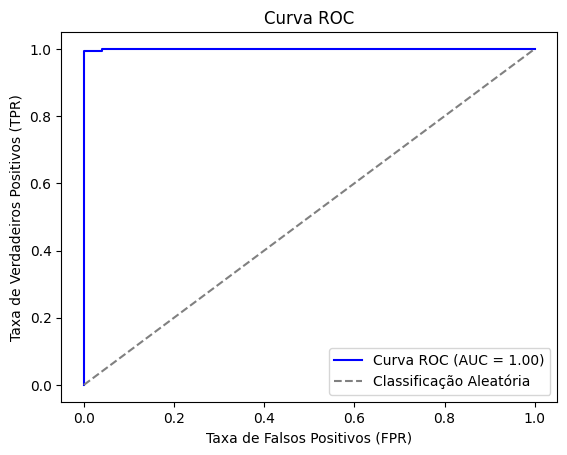

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
# Calcule a curva ROC
y_pred_prob = model.predict(test_generator, steps=steps_test, verbose=1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcule a AUC (Área sob a curva)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificação Aleatória')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Matriz de Confusão:
 [[198   0]
 [  2 196]]


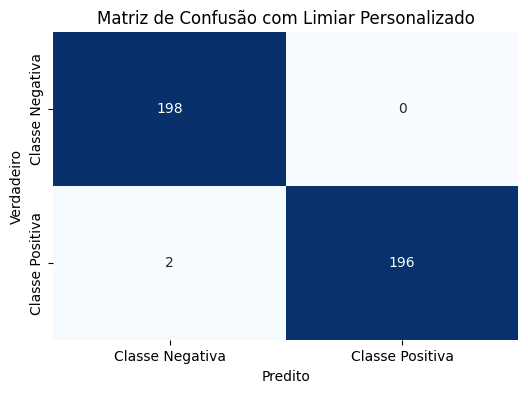

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calcule as probabilidades preditas
y_pred_prob = model.predict(X_test)

# Converta as probabilidades em rótulos binários (0 ou 1) usando o limiar 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcule a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

print("Matriz de Confusão:\n", cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe Negativa", "Classe Positiva"],
            yticklabels=["Classe Negativa", "Classe Positiva"])
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão com Limiar Personalizado")
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


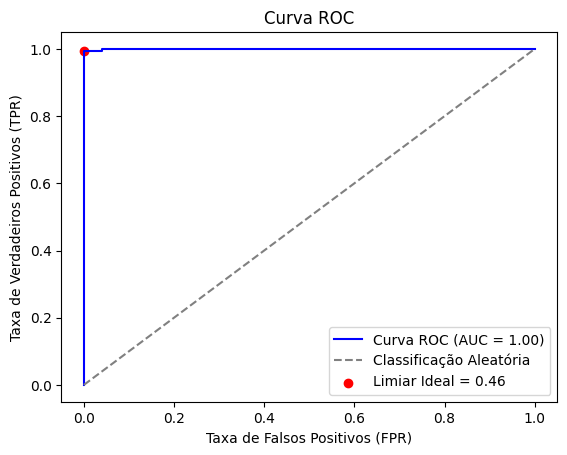

Limiar de decisão ideal: 0.45540425181388855
Acurácia no limiar ideal: 0.9974747474747475


In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, auc
import numpy as np
import matplotlib.pyplot as plt

# Calcule as probabilidades preditas
y_pred_prob = model.predict(X_test)

# Calcule a curva ROC e os limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Encontre o limiar ideal que maximiza a distância do ponto (0, 1)
distances = np.sqrt((1 - tpr)**2 + fpr**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

# Calcule a acurácia no limiar ideal
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(y_test, y_pred_optimal)

# Exibe a curva ROC e o limiar ideal
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificação Aleatória')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Limiar Ideal = {optimal_threshold:.2f}')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Imprime os resultados
print(f"Limiar de decisão ideal: {optimal_threshold}")
print(f"Acurácia no limiar ideal: {optimal_accuracy:}")


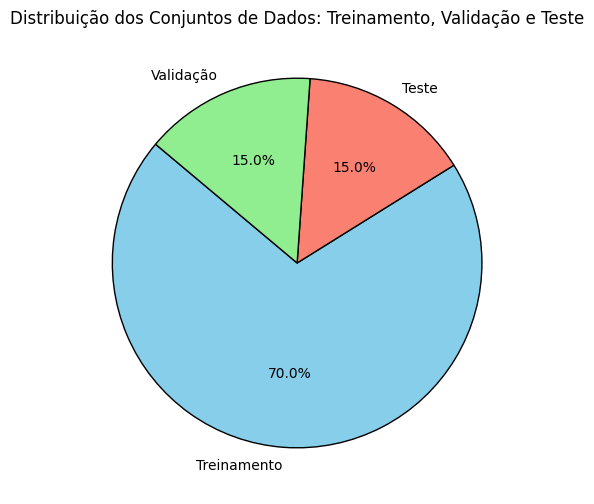

In [ ]:
# Código em Python para gerar o gráfico de pizza com as proporções dos conjuntos de dados

# Importa as bibliotecas necessárias
import matplotlib.pyplot as plt

# Define as quantidades de amostras em cada conjunto
quantidades = [1847, 396, 396]
labels = ['Treinamento', 'Teste', 'Validação']
colors = ['skyblue', 'salmon', 'lightgreen']

# Cria o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(quantidades, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Distribuição dos Conjuntos de Dados: Treinamento, Validação e Teste")
plt.show()
